# Watershed Distance Transform for 2D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [13]:
import os
import errno
import numpy as np
import deepcell
from tensorflow.python import keras
import matplotlib.pyplot as plt


In [2]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 81  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# Sample mode settings
batch_size = 64  # number of images per batch (should be 2 ^ n)
win = (receptive_field - 1) // 2  # sample window size
balance_classes = True  # sample each class equally
max_class_samples = 1e6  # max number of samples per class

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance "classes"
erosion_width = 2  # erode edges
LOG_DIR = '/data/logs'

In [3]:
base_name = 'Training_Freeze_1_Nuc_HH3'
npz_name = '/data/npz_data/' + base_name + ".npz"
MODEL_DIR = '/data/models/' + '20190914_tuning'
MODEL_NAME = base_name + "_watershed_81_rf_256_dense_64_conv_2erosion"

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

### Load the Training Data

In [4]:
CHANNEL_AXIS = 3
training_data = np.load(npz_name)

X, y = training_data["X"], training_data["y"]
print("X.shape: {} & y.shape: {}".format(X.shape, y.shape))

X.shape: (4, 1024, 1024, 1) & y.shape: (4, 1024, 1024, 1)


### Create a model for the watershed energy transform

#### Instantiate the distance transform model

In [5]:
from deepcell import model_zoo
from deepcell.training import train_model_sample

watershed_model = model_zoo.bn_feature_net_2D(
    receptive_field=receptive_field,
    n_channels=X.shape[CHANNEL_AXIS],
    n_features=distance_bins,
    n_conv_filters=64,
    n_dense_filters=256)

In [6]:
MODEL_NAME

'Training_Freeze_1_Nuc_HH3_watershed_81_rf_256_dense_64_conv_2erosion'

#### Train the model

In [8]:
watershed_model = train_model_sample(
    model=watershed_model,
    dataset=npz_name, 
    model_name=MODEL_NAME,
    test_size=test_size,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=10,
    window_size=(win, win),
    transform=transform,
    distance_bins=distance_bins,
    erosion_width=erosion_width,
    balance_classes=True,
    max_class_samples=320000,
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2),
    val_monitor=False,
    save_period=1)

using all data as training data
Using class weights of {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
X_train shape: (4, 1024, 1024, 1)
y_train shape: (4, 1024, 1024, 1)
Output Shape: (None, 4)
Number of Classes: 4
Training on 1 GPUs
the max_class_samples per image is 80000
analyzing image 0
the least represented class has 41073 examples
analyzing class 0
downsampling from 624037 examples per class
analyzing class 1
downsampling from 135505 examples per class
analyzing class 2
downsampling from 88634 examples per class
analyzing class 3
downsampling from 41073 examples per class
analyzing image 1
the least represented class has 36892 examples
analyzing class 0
downsampling from 656297 examples per class
analyzing class 1
downsampling from 116908 examples per class
analyzing class 2
downsampling from 79152 examples per class
analyzing class 3
downsampling from 36892 examples per class
analyzing image 2
the least represented class has 30629 examples
analyzing class 0
downsampling from 692322 examples 

In [7]:
hist = np.load(os.path.join(MODEL_DIR, MODEL_NAME + ".npz"))
hist['loss_history'].tolist()['acc']

[0.6211040026246719,
 0.6423166830708661,
 0.649165436351706,
 0.6528170795056868,
 0.656289301727909,
 0.6601374535214348,
 0.6614925087489064,
 0.6645734224628171,
 0.6661096073928259,
 0.6672869504593176]

In [8]:
EPOCH_NAME = "_epoch_06"
watershed_weights_file = os.path.join(MODEL_DIR, MODEL_NAME + EPOCH_NAME + ".h5")

In [9]:
# load watershed model
run_watershed_model = model_zoo.bn_feature_net_2D(
    dilated=True,
    receptive_field=receptive_field,
    n_features=distance_bins,
    input_shape=tuple(X.shape[1:]), 
    n_conv_filters=64,
    n_dense_filters=256)
run_watershed_model.load_weights(watershed_weights_file)

In [10]:
# run the model
test_images = run_watershed_model.predict(X[:1, ...])

In [11]:
argmax_images = []
for j in range(test_images.shape[0]):
    argmax_images.append(np.argmax(test_images[j, ...], axis=-1))
argmax_images = np.array(argmax_images)

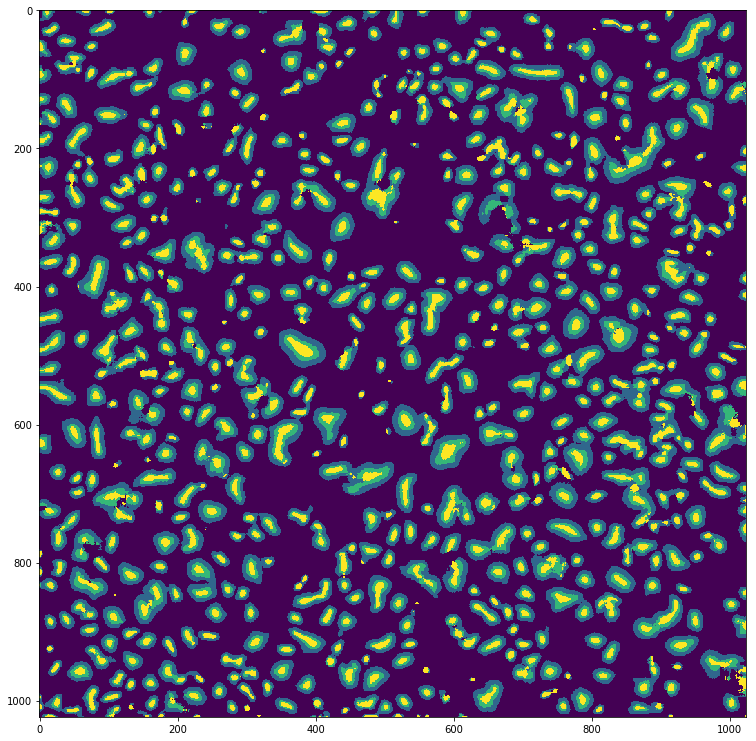

In [14]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :])

In [ ]:
xr_output = xr.DataArray(test_images, name=MODEL_NAME,
                         coords=[['point8'], range(1024), range(1024), ['level_0', 'level_1', 'level_2', 'level_3']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output.to_netcdf(os.path.join('/data/models', "20190914_tuning", MODEL_NAME + "point1_output.nc"))

In [ ]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :])